# **Notebook 04 – Retail Sales Forecasting**

**1️⃣ Imports & Global Configuration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import sys

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)]
)

logger = logging.getLogger("Notebook04_Forecasting")


**2️⃣ Load Forecast-Ready Dataset**

In [ ]:
def load_data(path):
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")
    logger.info(f"Dataset loaded: {df.shape[0]} rows")
    return df


In [ ]:
df = load_data(
    "/content/drive/MyDrive/retaildataanalysis/dataset/outputs/retail_kpi.csv"
)


**3️⃣ Train–Test Split (Time-Series Safe)**

In [ ]:
def train_test_split_ts(df, horizon):
    train = df.iloc[:-horizon]
    test = df.iloc[-horizon:]
    logger.info(f"Train size: {len(train)}, Test size: {len(test)}")
    return train, test


In [ ]:
FORECAST_HORIZON = 12
train, test = train_test_split_ts(df, FORECAST_HORIZON)


**4️⃣ Evaluation Utilities**

In [ ]:
def evaluate_forecast(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)

    rmse = mean_squared_error(y_true, y_pred) ** 0.5

    logger.info(
        f"{model_name} | MAE: {mae:.2f} | RMSE: {rmse:.2f}"
    )

    return {
        "model": model_name,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2)
    }


In [ ]:
rmse = mean_squared_error(y_true, y_pred, squared=False)

**5️⃣ Baseline Model (Naïve Forecast)**

In [ ]:
def naive_forecast(train, horizon):
    last_value = train["retail_index"].iloc[-1]
    return np.repeat(last_value, horizon)


In [ ]:
baseline_pred = naive_forecast(train, FORECAST_HORIZON)
baseline_metrics = evaluate_forecast(
    test["retail_index"],
    baseline_pred,
    "Naive Baseline"
)


**6️⃣ Holt-Winters Forecast**

In [ ]:
def holt_winters_forecast(train, horizon):
    model = ExponentialSmoothing(
        train["retail_index"],
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    fitted = model.fit()
    return fitted.forecast(horizon)


In [ ]:
hw_pred = holt_winters_forecast(train, FORECAST_HORIZON)
hw_metrics = evaluate_forecast(
    test["retail_index"],
    hw_pred,
    "Holt-Winters"
)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**7️⃣ ARIMA Forecast**

In [ ]:
def arima_forecast(train, horizon, order=(1,1,1)):
    model = ARIMA(train["retail_index"], order=order)
    fitted = model.fit()
    return fitted.forecast(steps=horizon)


In [ ]:
arima_pred = arima_forecast(train, FORECAST_HORIZON)
arima_metrics = evaluate_forecast(
    test["retail_index"],
    arima_pred,
    "ARIMA(1,1,1)"
)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**8️⃣ Model Comparison Table**

In [ ]:
results = pd.DataFrame([
    baseline_metrics,
    hw_metrics,
    arima_metrics
]).sort_values("RMSE")

results


,model,MAE,RMSE
1,Holt-Winters,1.57,1.80
0,Naive Baseline,6.19,8.19
2,"ARIMA(1,1,1)",9.53,10.73


**9️⃣ Forecast Visualization**

In [ ]:
def plot_forecasts(train, test, forecasts):
    plt.figure(figsize=(12,6))

    plt.plot(train.index, train["retail_index"], label="Train")
    plt.plot(test.index, test["retail_index"], label="Actual", color="black")

    for name, values in forecasts.items():
        plt.plot(test.index, values, label=name)

    plt.title("Retail Sales Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel("Retail Index")
    plt.legend()
    plt.grid(True)
    plt.show()


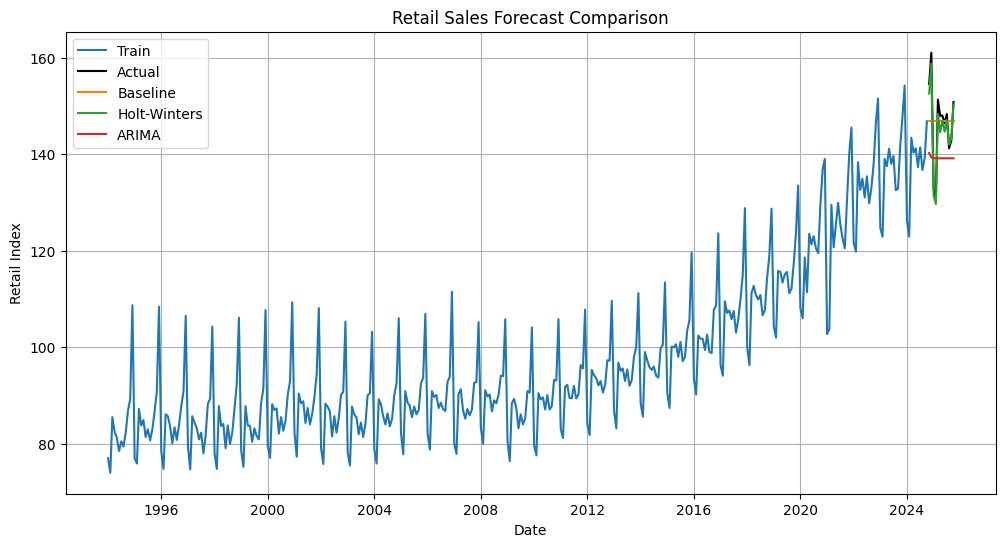

In [ ]:
plot_forecasts(
    train,
    test,
    {
        "Baseline": baseline_pred,
        "Holt-Winters": hw_pred,
        "ARIMA": arima_pred
    }
)


**🔟 Final Production Forecast**

In [ ]:
def final_forecast(df, horizon):
    model = ExponentialSmoothing(
        df["retail_index"],
        trend="add",
        seasonal="add",
        seasonal_periods=12
    )
    fitted = model.fit()
    return fitted.forecast(horizon)


In [ ]:
future_forecast = final_forecast(df, 12)
future_forecast


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,0
2025-11-01,157.944390
2025-12-01,164.004222
2026-01-01,136.309464
2026-02-01,134.301822
2026-03-01,153.677984
2026-04-01,149.795457
2026-05-01,151.293705
2026-06-01,149.339750
2026-07-01,151.643083
2026-08-01,145.975433


**1️⃣1️⃣ Save Forecast Output**

In [ ]:
forecast_df = future_forecast.reset_index()
forecast_df.columns = ["date", "forecast_retail_index"]

forecast_df.to_csv(
    "/content/drive/MyDrive/retaildataanalysis/dataset/outputs/retail_forecast.csv",
    index=False
)

logger.info("Forecast output saved successfully")


**1️⃣2️⃣ Unit Tests**

In [ ]:
def test_forecast_length(pred, horizon):
    assert len(pred) == horizon, "Forecast horizon mismatch"

def test_no_nan(pred):
    assert not pd.isna(pred).any(), "NaN values in forecast"

def test_positive_values(pred):
    assert (pred >= 0).all(), "Negative forecast values detected"


In [ ]:
for model_name, pred in {
    "Baseline": baseline_pred,
    "Holt-Winters": hw_pred,
    "ARIMA": arima_pred
}.items():
    test_forecast_length(pred, FORECAST_HORIZON)
    test_no_nan(pred)
    test_positive_values(pred)

logger.info("All forecasting unit tests passed ✅")
